## Mars_Rover_Project

In [108]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
#imageio.plugins.ffmpeg.download()

## Quick Look at the Data
There's some example data provided in the `test_dataset` folder.  This basic dataset is enough to get you up and running but if you want to hone your methods more carefully you should record some data of your own to sample various scenarios in the simulator.  

Next, read in and display a random image from the `test_dataset` folder

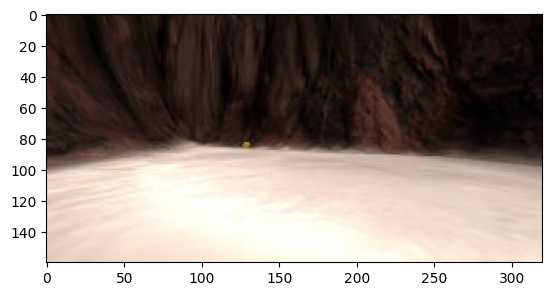

In [216]:
path = '../rec/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list) - 1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Calibration Data
Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 

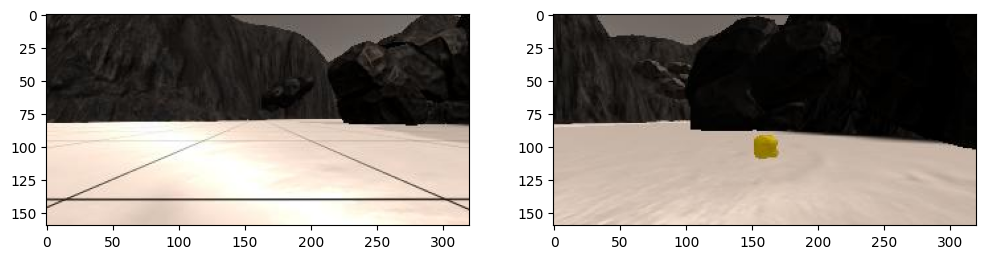

In [74]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = "../calibration_images/example_grid1.jpg"
example_rock = "../calibration_images/example_rock1.jpg"
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

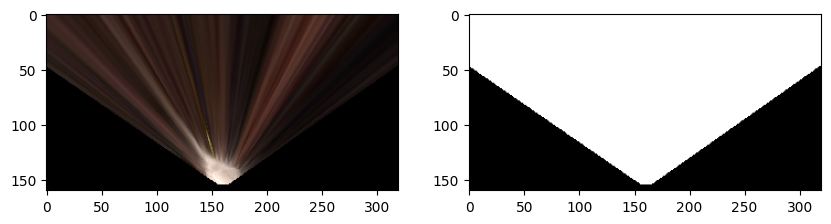

In [218]:
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst) # keeping the same size as input img
    wr_pt = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    return wr_pt


dst_size = 5
bottom_offset = 6

# 1) Define source and destination points for perspective transform
src = np.float32([[14, 140], [300, 140], [200, 95], [120, 95]])

destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                            [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                            [image.shape[1]/2 + dst_size, image.shape[0] - 2 * dst_size - bottom_offset],
                            [image.shape[1]/2 - dst_size, image.shape[0] - 2 * dst_size - bottom_offset]])

# 2) Apply perspective transform
wr_pt = perspect_transform(image, src, destination)
fig=plt.figure(figsize=(10,3))
plt.subplot(121)
plt.imshow(wr_pt)
plt.subplot(122)
mask = perspect_transform(np.ones_like(image[:,:,0]), src, destination)
plt.imshow(mask, cmap='gray')
#scipy.misc.imsave('../output/warped_example.jpg', warped)

## Color Thresholding
Define the color thresholding function from the lesson and apply it to the warped image

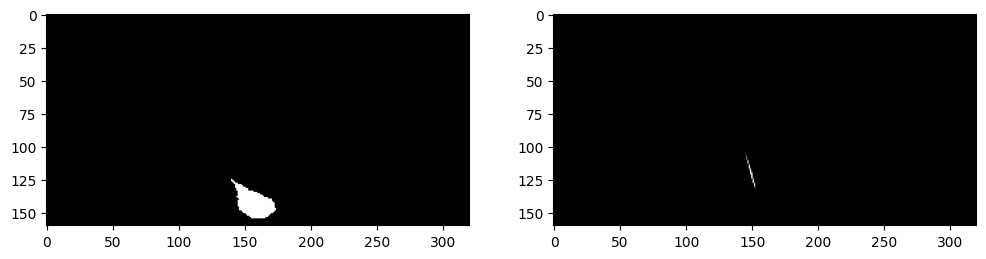

In [220]:
# Identify pixels above and below threshold interval
def color_thresh(img, above_thresh,below_thresh=(600,600,600)): 
     # Create an array of zeros same xy size as img, but single channel 
     color_select = np.zeros_like(img[:,:,0]) 
     # Require that each pixel be above all three threshold values in RGB 
     # above_thresh will now contain a boolean array with "True" 
     # where threshold was met 
     above_thresh_result = (img[:,:,0] > above_thresh[0])\
                            & (img[:,:,1] > above_thresh[1])\
                            & (img[:,:,2] > above_thresh[2]) 
     # Index the array of zeros with the boolean array and set to 1 
     color_select[above_thresh_result] = 1 
  
    
     below_thresh_result = (img[:,:,0] > below_thresh[0]) \
            & (img[:,:,1] > below_thresh[1]) \
            & (img[:,:,2] > below_thresh[2]) 
     
     # Index the array of zeros with the boolean array and set to 1 
     color_select[below_thresh_result] = 0
     
     # Return the binary image 
     return color_select


fig=plt.figure(figsize=(12,3))
terrain_img = color_thresh(wr_pt, (150, 150, 150))
plt.subplot(121)
plt.imshow(terrain_img, cmap='gray')
lower_yellow = np.array([24 - 5, 100, 100])
upper_yellow = np.array([24 + 5, 255, 255])
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV) # Convert BGR to HSV
rock_samples = cv2.inRange(hsv, lower_yellow, upper_yellow) # Threshold the HSV image to get only upper_yellow colors
plt.subplot(122)
rock_samples = perspect_transform(rock_samples, src, destination)
plt.imshow(rock_samples, cmap='gray')

white = cv2.bitwise_not(np.zeros_like(image))
warped_white = perspect_transform(white, src, destination)
warped_white_threshed = color_thresh(warped_white, (1,1,1))  
not_terrain = cv2.bitwise_not(terrain_img) # invert the terrain image 
obstacle = cv2.bitwise_and(warped_white_threshed,not_terrain)

#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

# Adjust to world Coordinates

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

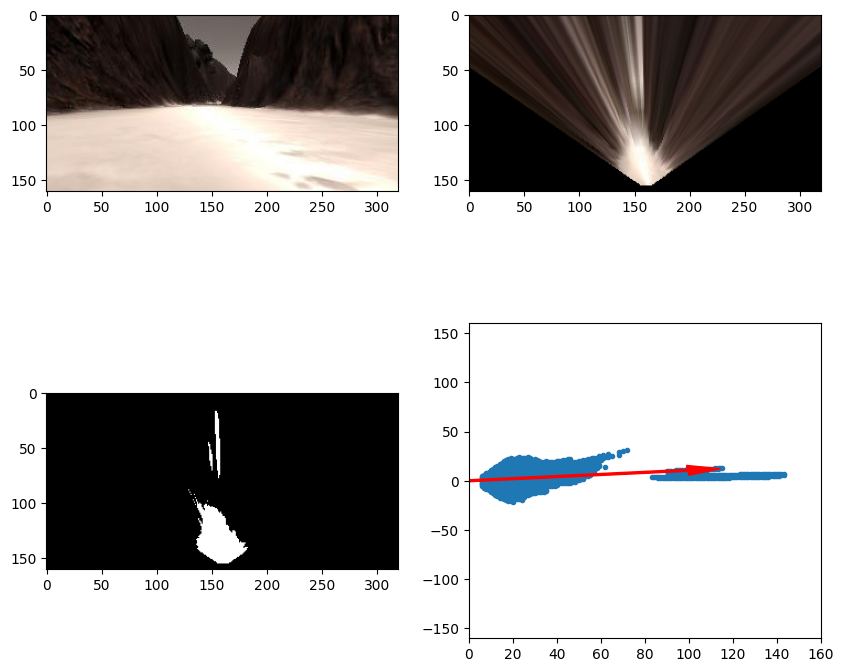

In [90]:
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the
    # center bottom of the image.
    x_pixel = -(ypos - binary_img.shape[0]).astype(float)
    y_pixel = -(xpos - binary_img.shape[1]/2).astype(float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle)
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))

    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale):
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# picking another random image
image = mpimg.imread(img_list[np.random.randint(0, len(img_list)-1)])
wr_pt = perspect_transform(image, source, destination)
terrain_img = color_thresh(wr_pt, (150, 150, 150))

# Adjusting Coordinates
x_pixel_rover, y_pixel_rover = rover_coords(terrain_img)  # terrain rover 
x_pixel_obstacle,y_pixel_obstacle = rover_coords(obstacle) # obstacle rover
x_pixel_rock,y_pixel_rock = rover_coords(rock_samples)
dist, angles = to_polar_coords(x_pixel_rover, y_pixel_rover)
mean_dir = np.mean(angles)

# Plotting
fig = plt.figure(figsize=(10,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(wr_pt)
plt.subplot(223)
plt.imshow(terrain_img, cmap='gray')
plt.subplot(224)
plt.plot(x_pixel_rover, y_pixel_rover, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)